In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

from utils import load_parquet_to_df_list, z_normalize
from approximation.paa import PAA
from discretization.sax.adaptive_sax import AdaptiveSAX
from discretization.sax.one_d_sax import OneDSAX
from information_embedding_cost.kullback_leibler_divergence import compute_raw_prob_distribution, compute_symbolic_prob_distribution, EquiWidth

ImportError: cannot import name 'compute_raw_prob_distribution' from 'information_embedding_cost.kullback_leibler_divergence' (c:\users\danie\documents\karlsruhe\03_kit_studium\07_semester\bachelorarbeit\bachelorarbeit\repo\implementation\1_code\src\information_embedding_cost\kullback_leibler_divergence.py)

In [2]:
# load time series dataset into dataframe and z-normalize it
path = "../../../0_data/UCRArchive_2018/SwedishLeaf/train"
df_list = load_parquet_to_df_list(path)

# concatenate all time series to one dataframe, because they all have the same length
df_norm = pd.concat([z_normalize(df["signal"].to_frame()) for df in df_list], axis=1).iloc[:, :1]
df_norm

,signal
0,2.223633
1,2.058567
2,1.849589
3,1.642328
4,1.438219
...,...
123,1.345195
124,1.547908
125,1.760490
126,1.970141


In [3]:
alphabet_size = 9
window_size = 5

a_sax = AdaptiveSAX(alphabet_size)
equi_width_binning = EquiWidth()

df_raw_prob_distr = compute_raw_prob_distribution(df_norm, a_sax, equi_width_binning)
df_raw_prob_distr

,0
a,0.312500
b,0.148438
c,0.109375
d,0.085938
e,0.101563
f,0.062500
g,0.062500
h,0.054688
i,0.062500


In [4]:
df_paa = PAA(window_size).transform(df_norm)
df_symbolic_prob_distr = compute_symbolic_prob_distribution(df_paa, df_norm, window_size, a_sax)
df_symbolic_prob_distr

,signal
a,0.153846
b,0.153846
c,0.153846
d,0.076923
e,0.038462
f,0.115385
g,0.076923
h,0.076923
i,0.153846


In [5]:
entropy(df_raw_prob_distr, df_symbolic_prob_distr)

array([0.16071401])

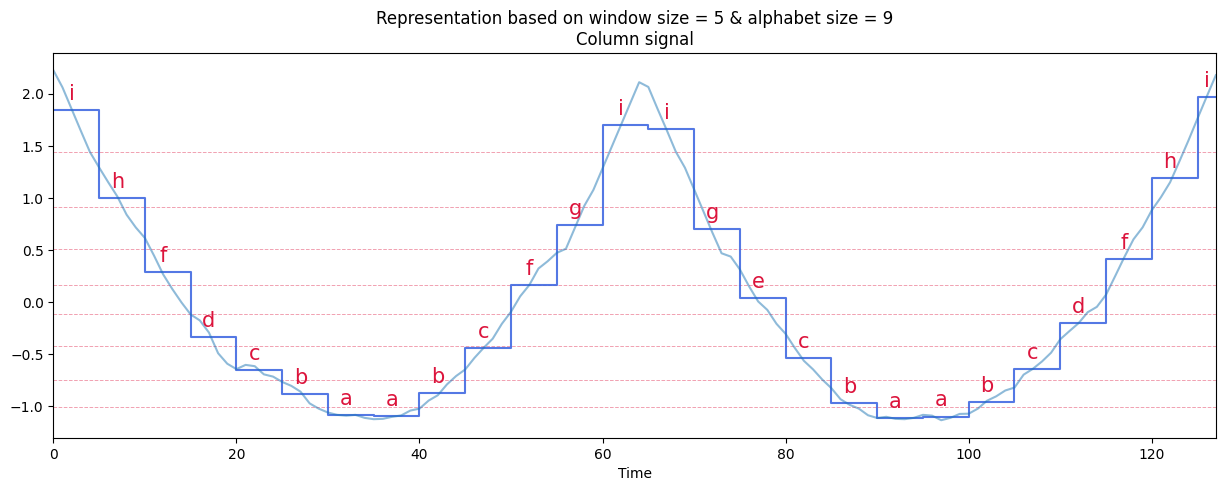

In [6]:
from discretization.sax.graphics import plot_paa_sax_symbols

df_a_sax, df_breakpoints = a_sax.transform(df_paa)
# PAA representation with respective SAX symbols of intervals
plot_paa_sax_symbols(df_norm, df_paa, df_a_sax, a_sax.breakpoints, a_sax.alphabet_size, window_size, num_column=0)

In [7]:
df_norm_new = df_norm.iloc[:, 0]
df_scaled = (df_norm_new - df_norm_new.min()) / (df_norm_new.max() - df_norm_new.min())

In [8]:
# quantile binning
bins = 10

pd.qcut(df_scaled, bins).value_counts()

(-0.001, 0.0135]    13
(0.0135, 0.0374]    13
(0.0374, 0.103]     13
(0.161, 0.265]      13
(0.265, 0.362]      13
(0.478, 0.638]      13
(0.638, 0.807]      13
(0.807, 1.0]        13
(0.103, 0.161]      12
(0.362, 0.478]      12
Name: signal, dtype: int64

In [9]:
# equal width histogram
hist, bins = np.histogram(df_scaled, bins=bins, range=(df_scaled.min(), df_scaled.max()), density=False)
hist

array([38, 19, 11, 12, 11,  9,  7,  8,  6,  7], dtype=int64)

In [10]:
df_a_sax = a_sax.transform(df_paa)[0].iloc[:, 0].to_frame()
df_a_sax

,signal
0,i
1,h
2,f
3,d
4,c
5,b
6,a
7,a
8,b
9,c


In [11]:
mapping = {symbol: idx for idx, symbol in enumerate(a_sax.alphabet)}
df_a_sax = df_a_sax.replace(mapping)
df_a_sax_scaled = (df_a_sax - df_a_sax.min()) / (df_a_sax.max() - df_a_sax.min())
df_a_sax_scaled

,signal
0,1.000
1,0.875
2,0.625
3,0.375
4,0.250
5,0.125
6,0.000
7,0.000
8,0.125
9,0.250


In [12]:
hist, bins = np.histogram(df_a_sax_scaled, bins=10, range=(0, 1), density=False)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [13]:
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [14]:
pd.qcut(df_a_sax_scaled.iloc[:, 0], 10, duplicates="drop").value_counts()

(-0.001, 0.125]    8
(0.188, 0.25]      4
(0.375, 0.625]     4
(0.688, 0.875]     4
(0.875, 1.0]       4
(0.25, 0.375]      2
(0.125, 0.188]     0
(0.625, 0.688]     0
Name: signal, dtype: int64